<a href="https://colab.research.google.com/github/weisben/adversarial-examples/blob/main/Adv_Input_STL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Example Generator

I use FGSM to generate images which fool a ResNet trained on the STL-10 dataset.

### Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable

### Sources

In the making of this project, I referenced this [PyTorch tutorial](https://savan77.github.io/blog/imagenet_adv_examples.html) and this [paper](https://download.arxiv.org/pdf/2009.03728v1.pdf).

## [STL-10 Dataset](https://cs.stanford.edu/~acoates/stl10/)

The STL-10 Dataset contains hundereds of thousands of 95x95 images in 10 classes. The classes are as follows:
* airplane
* bird
* car
* cat
* deer
* dog
* horse
* monkey
* ship
* truck

The lower resolution and small number of classes make this data set ideal for tuning a model.

In [2]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

# Datasets
dsets = {x: datasets.STL10(root='./data', download=True, transform=preprocess)
         for x in ['train', 'test']}
# Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16, shuffle=(x == "train"))
               for x in ['train', 'test']}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Dictionaries to go between labels (ints) and names (strings)
LABEL_TO_NAME = {0:'airplane', 1:'bird', 2:'car', 3:'cat', 4:'deer', 5:'dog', 6:'horse', 7:'monkey', 8:'ship', 9:'truck'}
NAME_TO_LABEL = {'airplane':0, 'bird':1, 'car':2, 'cat':3, 'deer':4, 'dog':5, 'horse':6, 'monkey':7, 'ship':8, 'truck':9}

## Training ResNet34

ResNet34 is an image classification model which uses deep residual connections. It is originally trained on the ImageNet dataset, which has 1000 output classes. Here, we will change the output classes to 10 for STL-10.

In [4]:
# ResNet34 with a modified last layer to allow for 10 classes
model = models.resnet34(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 10)

Now, we can train ResNet34 on STL-10. The training process will be relatively quick since the ResNet is already accustomed to classifying images. We will be using Cross Entropy Loss and the Adam optimizer.

In [5]:
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

num_epochs = 10

In [6]:
# Training loop from demo 5
for epoch in range(num_epochs):

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) 
                _, preds = torch.max(outputs, 1) 
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)

        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


Epoch:0 -- Phase:train -- Loss:1.45 -- Acc:49.36
Epoch:0 -- Phase:test -- Loss:1.05 -- Acc:61.78
Epoch:1 -- Phase:train -- Loss:0.95 -- Acc:66.78
Epoch:1 -- Phase:test -- Loss:0.73 -- Acc:74.02
Epoch:2 -- Phase:train -- Loss:0.70 -- Acc:75.74
Epoch:2 -- Phase:test -- Loss:0.61 -- Acc:78.68
Epoch:3 -- Phase:train -- Loss:0.58 -- Acc:80.42
Epoch:3 -- Phase:test -- Loss:0.34 -- Acc:88.64
Epoch:4 -- Phase:train -- Loss:0.40 -- Acc:85.88
Epoch:4 -- Phase:test -- Loss:0.31 -- Acc:89.50
Epoch:5 -- Phase:train -- Loss:0.34 -- Acc:88.24
Epoch:5 -- Phase:test -- Loss:0.19 -- Acc:94.38
Epoch:6 -- Phase:train -- Loss:0.24 -- Acc:92.28
Epoch:6 -- Phase:test -- Loss:0.07 -- Acc:97.82
Epoch:7 -- Phase:train -- Loss:0.17 -- Acc:94.32
Epoch:7 -- Phase:test -- Loss:0.21 -- Acc:92.84
Epoch:8 -- Phase:train -- Loss:0.18 -- Acc:94.14
Epoch:8 -- Phase:test -- Loss:0.14 -- Acc:95.00
Epoch:9 -- Phase:train -- Loss:0.16 -- Acc:94.82
Epoch:9 -- Phase:test -- Loss:0.16 -- Acc:94.94


Text(0.5, 1.0, 'Accuracy')

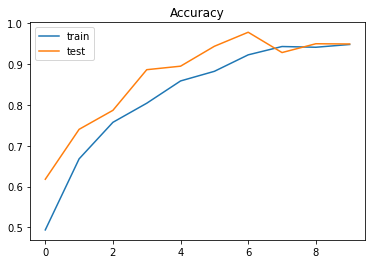

In [7]:
# Plot from demo 5
plt.plot(save_acc['train'])
plt.plot(save_acc['test'])
plt.legend(["train", "test"])
plt.title("Accuracy")

After just 10 epochs, the model already has very high accuracy (98% in my run). Now that we have trained ResNet34, we can now commence the process of tricking it.

## Fooling ResNet

Now, let's look at a specific image and see the different ways we can fool our image classification model.

In [8]:
images, labels = next(iter(dataloaders['train']))

In [9]:
# Change i to select a different item from the batch
i = 0
img = images[i].unsqueeze(0)
lab = labels[i]

In [10]:
# Transform to unnormalize images
# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
unNorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [11]:
# Original code
# Takes an image (1xCXHXW) and a label (tensor)
# Shows the image and its label and what the model predicts it as
def quick_classify(model, X, y):
  display = np.transpose(unNorm(X.squeeze()), (1,2,0)) # UnNormalize and Transpose image for display using plt
  name = LABEL_TO_NAME[y.numpy().item()]
  plt.imshow(display, cmap="gray")
  plt.axis('off')
  plt.show()
  print(f"True Label: {name}")

  # Quickly run the model on the image to get the predicted class and probability
  X = Variable(X, requires_grad=True)
  output = model(X)
  y_hat = torch.argmax(output).detach().numpy().item()
  pred_name = LABEL_TO_NAME[y_hat]
  pred_prob = round(100 * torch.max(F.softmax(output, dim=1)).detach().numpy().item(), 2)
  print(f"Predicted: {pred_name} ({pred_prob}%)")

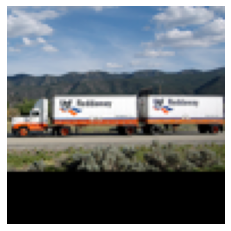

True Label: truck
Predicted: truck (100.0%)


In [12]:
quick_classify(model, img, lab)

This is our image! Let's see what we can do to it.

In [13]:
# Adapted from https://savan77.github.io/blog/imagenet_adv_examples.html
# Helper function to visualize a clean image, perturbation, and resulting adversarial input
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     
    x = unNorm(x) # unnormalize
    x = np.transpose( x , (1,2,0)) # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = unNorm(x_adv)
    x_adv = np.transpose( x_adv , (1,2,0))   
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))

    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    
    plt.show()

### Fast Gradient Sign Method (FGSM)

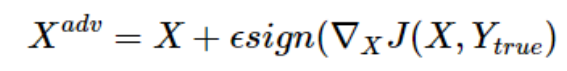

A very simple way to fool our image classification model is FGSM. Here, we input an image and calculate the sign of the gradient of the loss for that image. Then, we shift the image by that amount multiplied by a small value epsilon. Essentially, we are slightly altering each pixel in the image in the direction of the gradient, so that the loss will go up.

Note: The following functions were built with the help of https://savan77.github.io/blog/imagenet_adv_examples.html, and then improved/simplified.

In [14]:
# Takes a image classification model and an image X (ready to be processed) labeled y
# Creates and visualizes the result of the Fast Gradient Sign Method constrained by epsilon
def FGSM(model, X, y, epsilon):
  # Find loss of image
  X = Variable(X, requires_grad=True)
  output = model(X)
  target = Variable(torch.LongTensor([y]), requires_grad=False)
  criterion = torch.nn.CrossEntropyLoss()
  loss = criterion(output, target)
  loss.backward(retain_graph=True)

  # Follow the function above to find X_adv
  X_grad_sign = torch.sign(X.grad.data)
  X_adv = X.data + epsilon * X_grad_sign
  
  # Find new prediction
  output_adv = model(Variable(X_adv))

  # Variables for visualize function
  X_label = torch.argmax(output).detach().numpy().item()
  X_name = LABEL_TO_NAME[X_label]
  X_prob = round(100 * torch.max(F.softmax(output, dim=1)).detach().numpy().item(), 4)
  X_adv_label = torch.argmax(output_adv).detach().numpy().item()
  X_adv_name = LABEL_TO_NAME[X_adv_label]
  X_adv_prob = round(100 * torch.max(F.softmax(output_adv, dim=1)).detach().numpy().item(), 4)

  visualize(X.data, X_adv, X_grad_sign, epsilon, X_name, X_adv_name, X_prob, X_adv_prob)

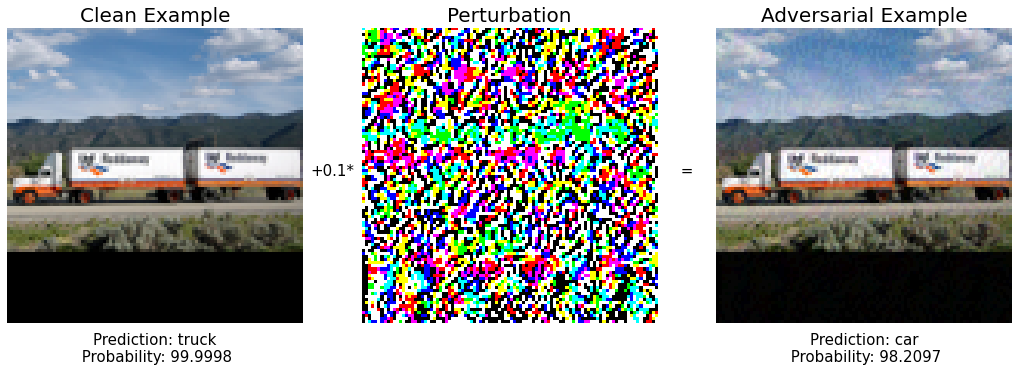

In [15]:
FGSM(model, img, lab, 0.1)

This works pretty well! We can change the epsilon to either make the perturbation more or less drastic. With a small perturbation, the prediction may stay the same but the probability will likely decrease. For larger perturbations, the prediction will likely change. However, the perturbation can be hardly visible and the model can still misclassify the image! This is because while the perturbation looks like random noise, it is very deliberately chosen based on the equation above.

### FGSM Targeted

We can also do FGSM with a target class in mind. All that we change is the loss function that we compute the gradient of.

In [16]:
# Takes a image classification model and an image X (ready to be processed) labeled y
# Creates and visualizes the result of the Fast Gradient Sign Method with target class t constrained by epsilon
def targetedFGSM(model, X, t, epsilon):
  # Fwd pass on clean
  X = Variable(X, requires_grad=True)
  output = model(X)
  target = Variable(torch.LongTensor([t]), requires_grad=False)
  criterion = torch.nn.CrossEntropyLoss()
  loss = -criterion(output, target) # notice that this has changed to negative - remember that we want to maximize this loss, not minimize
  loss.backward(retain_graph=True)

  # Equation
  X_grad_sign = torch.sign(X.grad.data)
  X_adv = X.data + epsilon * X_grad_sign
  
  # Fwd pass on adv
  output_adv = model(Variable(X_adv))
  
  # Labels & Probabilities
  X_label = torch.argmax(output).detach().numpy().item()
  X_name = LABEL_TO_NAME[X_label]
  X_prob = round(100 * torch.max(F.softmax(output, dim=1)).detach().numpy().item(), 4)
  X_adv_label = torch.argmax(output_adv).detach().numpy().item()
  X_adv_name = LABEL_TO_NAME[X_adv_label]
  X_adv_prob = round(100 * torch.max(F.softmax(output_adv, dim=1)).detach().numpy().item(), 4)

  visualize(X.data, X_adv, X_grad_sign, epsilon, X_name, X_adv_name, X_prob, X_adv_prob)

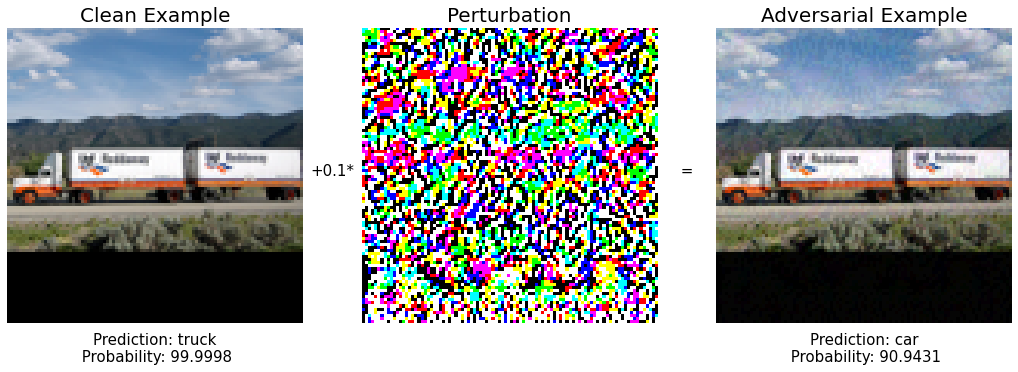

In [17]:
target_class = "dog"
target_label = NAME_TO_LABEL[target_class]
targetedFGSM(model, img, target_label, 0.1)

This method is pretty consistent but sometimes misses the target class.

### Iterative FGSM

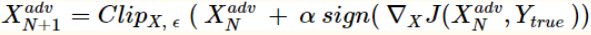

If we want to get even better results, we can improve our approach through iteration. Instead of taking one big step in the direction of the gradient, we can take several small steps - looking at the gradient each time.

In [18]:
# Takes an image and label and iteratively applies noise using FGSM
# Creates a new image after a certain number of steps under constraints alpha and epsilon
def iterFGSM(model, X, y, epsilon, alpha, num_steps):
  # Save original input since we will be modifying it iteratively
  X = Variable(X, requires_grad=True)
  output = model(X)
  orig = X.data
  target = Variable(torch.LongTensor([y]), requires_grad=False)

  criterion = torch.nn.CrossEntropyLoss()

  for _ in range(num_steps):
    if X.grad is not None: X.grad.zero_()
    # Forward
    output_adv = model(X)
    loss = criterion(output_adv, target)
    # Backward
    loss.backward()

    # Formula
    X_grad = alpha * torch.sign(X.grad.data)
    adv_temp = X.data + X_grad                
    total_grad = adv_temp - X.data
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    X_adv = X.data + total_grad
    X.data = X_adv

  # Last fwd pass on adv input
  output_adv = model(X)

  # Get labels & probs
  X_label = torch.argmax(output).detach().numpy().item()
  X_name = LABEL_TO_NAME[X_label]
  X_prob = round(100 * torch.max(F.softmax(output, dim=1)).detach().numpy().item(), 4)
  X_adv_label = torch.argmax(output_adv).detach().numpy().item()
  X_adv_name = LABEL_TO_NAME[X_adv_label]
  X_adv_prob = round(100 * torch.max(F.softmax(output_adv, dim=1)).detach().numpy().item(), 4)

  # Get final difference for purpose of visualizing
  difference = (X_adv.data - orig) / epsilon

  visualize(orig, X_adv.data, difference, epsilon, X_name, X_adv_name, X_prob, X_adv_prob)

In [19]:
# hyperparameters
epsilon = 0.01
num_steps = 10
alpha = 0.025

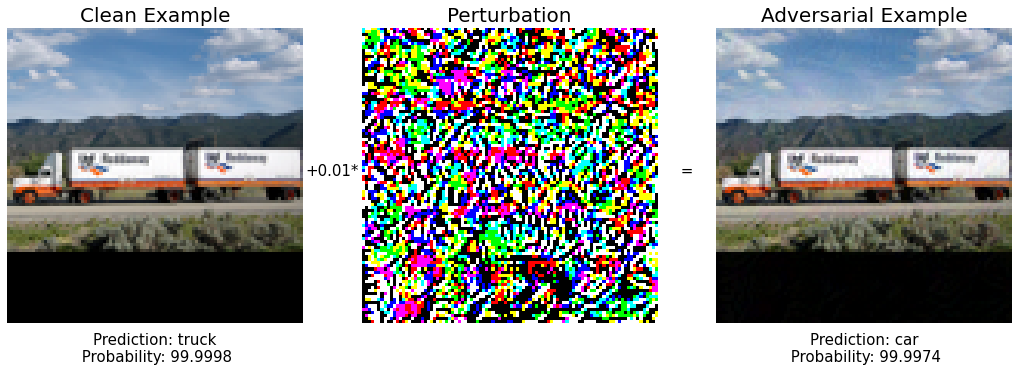

In [20]:
iterFGSM(model, img, lab, epsilon, alpha, num_steps)

This method works really well! Notice that we can use a very small epsilon and still get an incorrect prediction with very high probability.

### Iterative FGSM Targeted

Lastly, we can do FGSM iteratively with a target! This combines everything together and is quite effective.

In [21]:
def targetedIterFGSM(model, X, t, epsilon, alpha, num_steps):
  X = Variable(X, requires_grad=True)
  output = model(X)
  orig = X.data
  target = Variable(torch.LongTensor([t]), requires_grad=False)

  criterion = torch.nn.CrossEntropyLoss()

  for _ in range(num_steps):
    if X.grad is not None: X.grad.zero_()
    # Forward
    output_adv = model(X)
    loss = -criterion(output_adv, target) # note the negated loss again
    # Backward
    loss.backward()

    # Formula
    X_grad = alpha * torch.sign(X.grad.data)
    adv_temp = X.data + X_grad                
    total_grad = adv_temp - X.data
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    X_adv = X.data + total_grad
    X.data = X_adv

  output_adv = model(X)

  # Labels & Probs
  X_label = torch.argmax(output).detach().numpy().item()
  X_name = LABEL_TO_NAME[X_label]
  X_prob = round(100 * torch.max(F.softmax(output, dim=1)).detach().numpy().item(), 4)
  X_adv_label = torch.argmax(output_adv).detach().numpy().item()
  X_adv_name = LABEL_TO_NAME[X_adv_label]
  X_adv_prob = round(100 * torch.max(F.softmax(output_adv, dim=1)).detach().numpy().item(), 4)

  # Final total perturbation
  difference = (X_adv.data - orig) / epsilon

  visualize(orig, X_adv.data, difference, epsilon, X_name, X_adv_name, X_prob, X_adv_prob)


In [22]:
# hyperparameters
epsilon = 0.01
num_steps = 10
alpha = 0.025

Iterative FGSM with target airplane


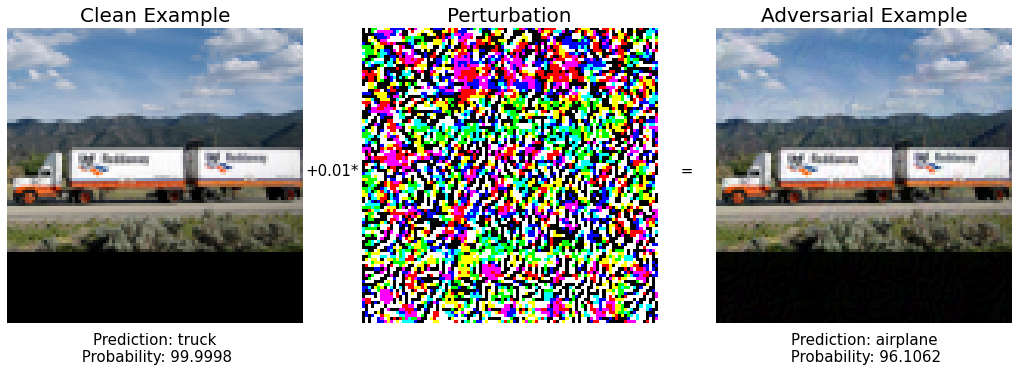

Iterative FGSM with target bird


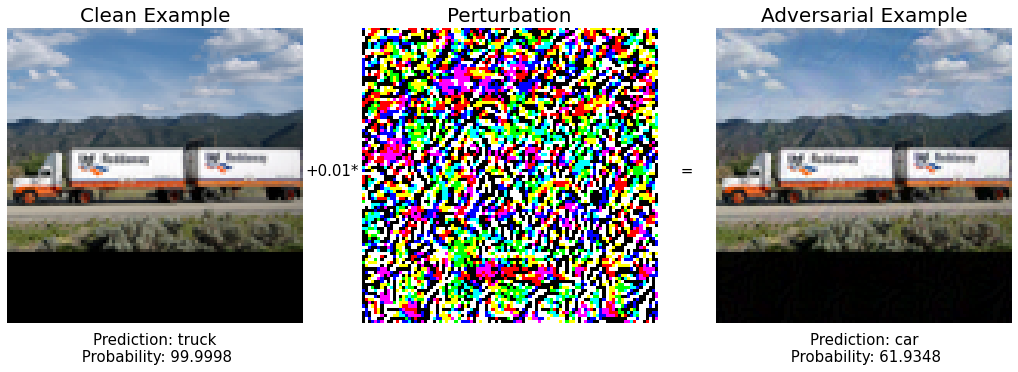

Iterative FGSM with target car


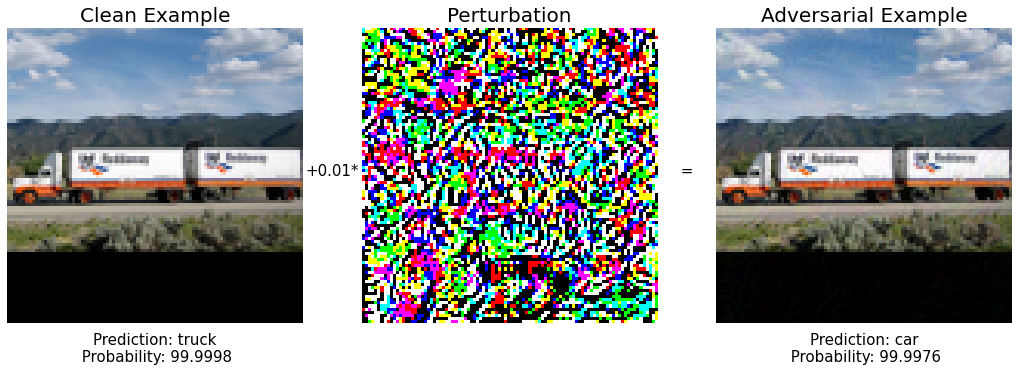

Iterative FGSM with target cat


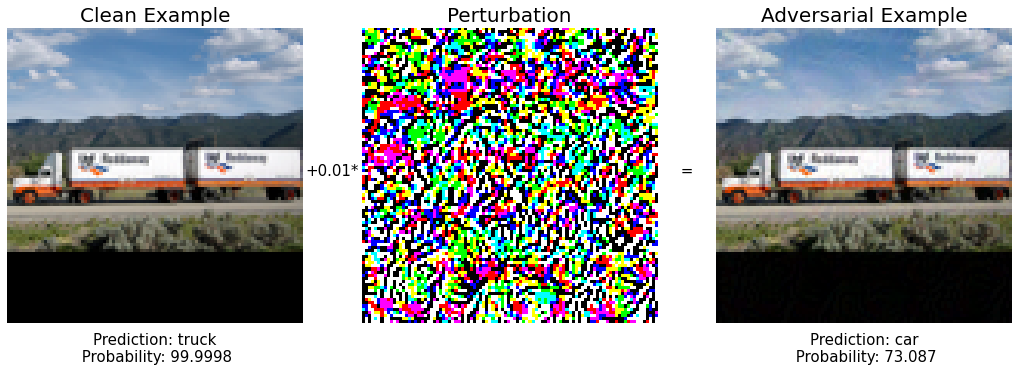

Iterative FGSM with target deer


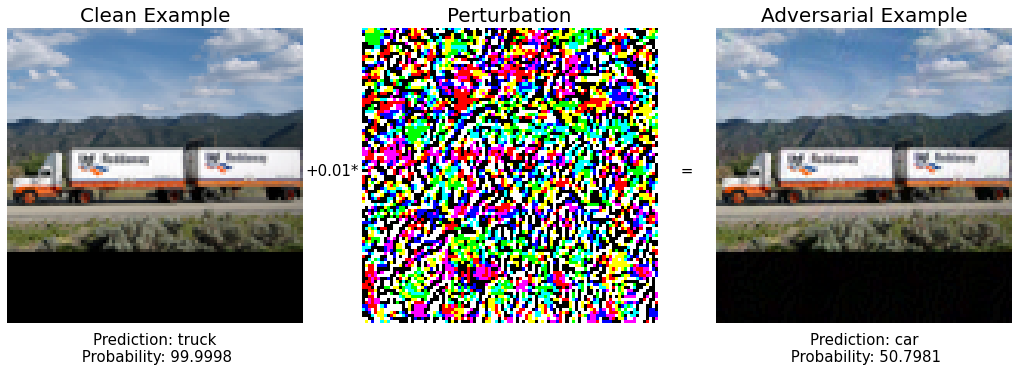

Iterative FGSM with target dog


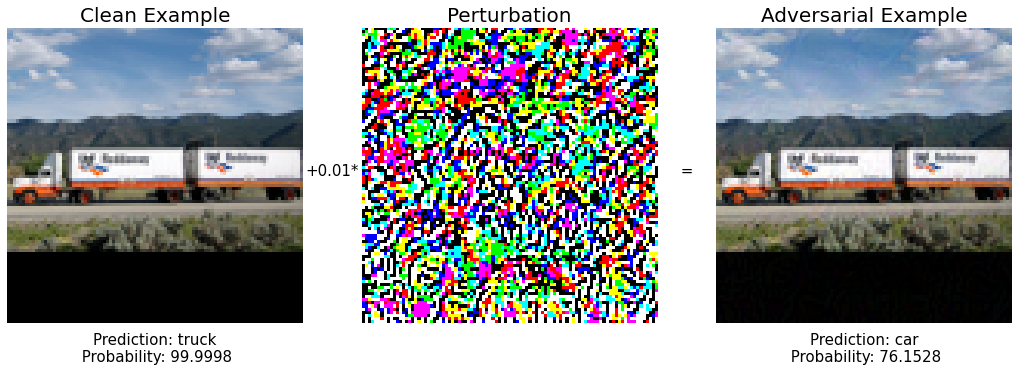

Iterative FGSM with target horse


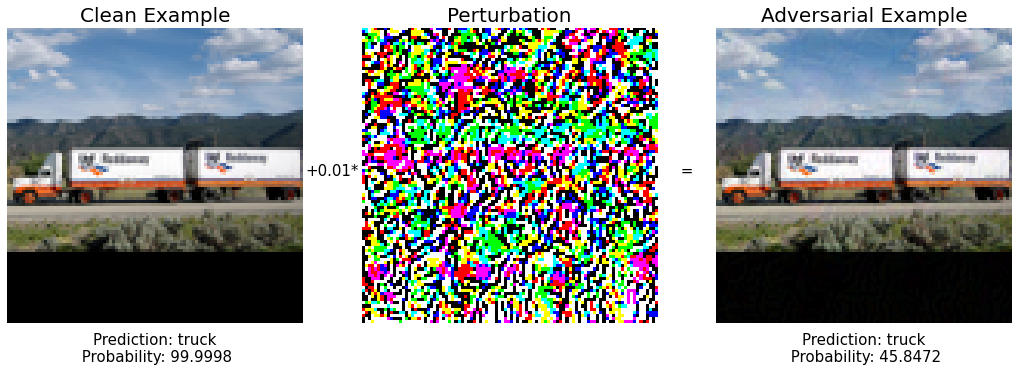

Iterative FGSM with target monkey


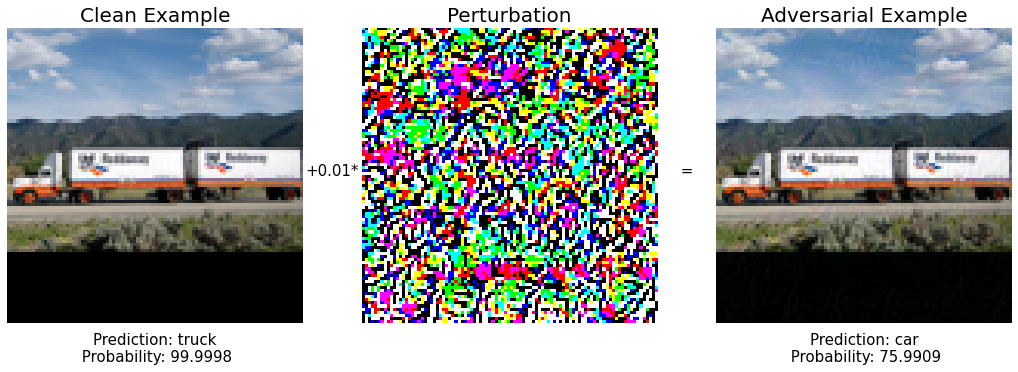

Iterative FGSM with target ship


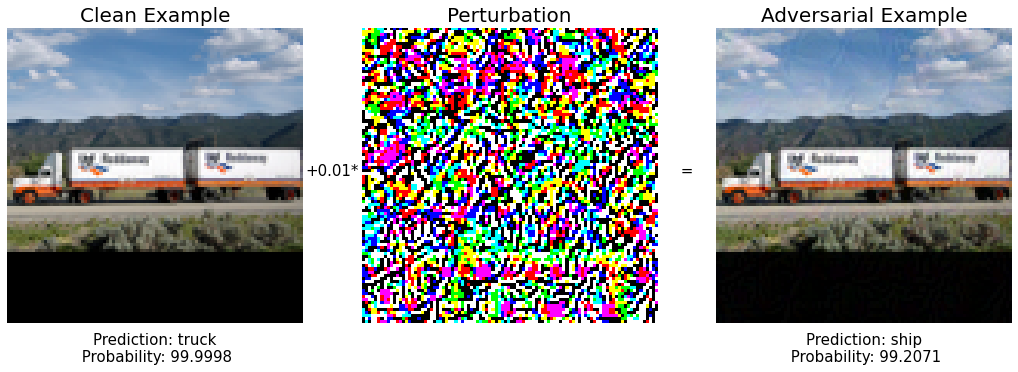

Iterative FGSM with target truck


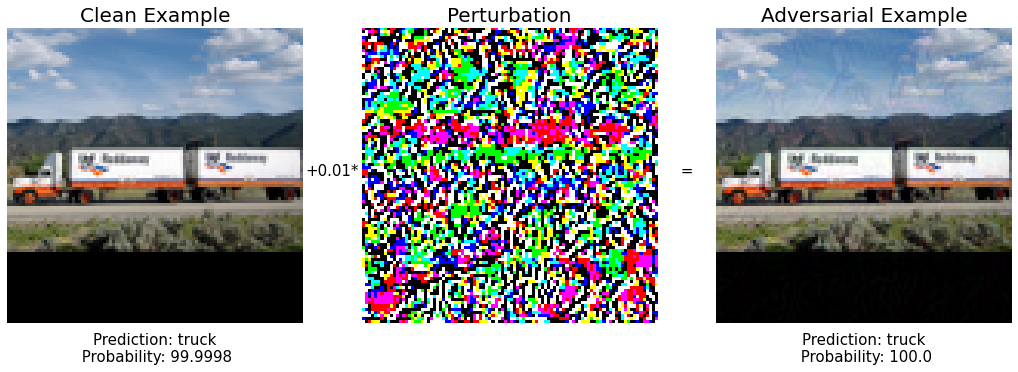

In [23]:
for i in range(10):
  print(f"Iterative FGSM with target {LABEL_TO_NAME[i]}")
  targetedIterFGSM(model, img, i, epsilon, alpha, num_steps)

This method can basically fool ResNet into thinking that any image is an example of any other class! You can try it with any image and any class - it works almost every time. In addition, at least with an epsilon of 0.01, we can see that the probability of the incorrect class is often higher than the probability of the original prediction - which is crazy. 

## Conclusion

My goal with using the STL-10 dataset and ResNet34 was to show that even with a strong image classification model and a small number of well-defined classes, we can still wreak havoc. However, we are only able to do this because we have access to the model and the parameters. Without this knowledge, the FSGM would be useless - this is why it is called a "white-box attack."

Another goal of this project was to have a simple but effective way of generating these adversarial examples. Feel free to play around with these attacks and see what can be done!